# SOLVING A BUSINESS OPTIMAL LOCATION PROBLEM

## Introduction

As the first part of this project to find the optimal location for a mexican restaurant in Madrid. It is first needed to analyze the city's most typical venues by neighborhood, so it is possible to have an idea of which are the actual leisure places where people go spend their time. To begin this analysis, neighborhood clusters will be created and their venues analysed in similarity terms.

Once the most frequent venues per neighborhood get extracted, for the second part of this project a segmentation by nationality of the people living in each neighborhood will be carried out, in order to determine in which neighborhood would be more advisable to open a mexican food restaurant based on the results of the previous segmentation and the analised venues.

For this project, the data that will be used to analyse the venues comes from the Foursquare API and the Madrid's City Hall. This project will be devoloped using the Python 3.6 programing language as the main working tool. To have access to the data used in this part, please refer to the first notebook: "Optimal location for a mexican restaurant". The data used in this motebook must be generated in the first notebook.

### Import necessary Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Read and import data

In [2]:
df = pd.read_csv('Madrid Neighborhoods.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
print(len(df))
df.head()

39


,Country of Procedence,Total Ciudad de Madrid,Centro,Arganzuela,Retiro,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas
0,Rumanía,45036.0,815.0,754.0,480.0,753.0,680.0,1468.0,597.0,1830.0,991.0,4904.0,5873.0,2241.0,4784.0,1286.0,2888.0,1466.0,3646.0,3384.0,2606.0,2929.0,661.0
1,China,37276.0,1508.0,1356.0,564.0,755.0,652.0,1988.0,816.0,1733.0,960.0,2554.0,4398.0,9207.0,3602.0,564.0,1960.0,1104.0,1236.0,685.0,472.0,972.0,190.0
2,Ecuador,23953.0,647.0,741.0,265.0,619.0,380.0,1395.0,453.0,632.0,387.0,2194.0,3674.0,1806.0,3290.0,491.0,2471.0,401.0,2017.0,498.0,439.0,1015.0,138.0
3,Venezuela,23359.0,1563.0,913.0,638.0,1564.0,933.0,1310.0,794.0,1428.0,630.0,1448.0,1870.0,875.0,1829.0,480.0,1858.0,1434.0,909.0,762.0,321.0,1486.0,314.0
4,Colombia,22618.0,998.0,717.0,483.0,803.0,551.0,822.0,659.0,999.0,454.0,1786.0,3395.0,1752.0,1733.0,482.0,1792.0,910.0,1618.0,740.0,384.0,1282.0,258.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country of Procedence   37 non-null     object 
 1   Total Ciudad de Madrid  34 non-null     float64
 2   Centro                  34 non-null     float64
 3   Arganzuela              34 non-null     float64
 4   Retiro                  34 non-null     float64
 5   Salamanca               34 non-null     float64
 6   Chamartin               34 non-null     float64
 7   Tetuán                  34 non-null     float64
 8   Chamberí                34 non-null     float64
 9   Fuencarral-El Pardo     34 non-null     float64
 10  Moncloa-Aravaca         34 non-null     float64
 11  Latina                  34 non-null     float64
 12  Carabanchel             34 non-null     float64
 13  Usera                   34 non-null     float64
 14  Puente de Vallecas      34 non-null     floa

In [4]:
df.fillna(method = 'ffill', inplace = True)
df.fillna(method = 'bfill', inplace = True)

### Create a new dataframe with the coordinates of Madrid's neighborhoods

In [5]:
coordinates_df = pd.DataFrame( data = {

'Neighborhood' : ['Centro', 'Arganzuela', 'Retiro', 'Salamanca', 'Chamartin',
                'Tetuán', 'Chamberí', 'Fuencarral-El Pardo', 'Moncloa-Aravaca', 'Latina', 'Carabanchel',
                'Usera', 'Puente de Vallecas', 'Moratalaz', 'Ciudad Lineal', 'Hortaleza', 'Villaverde',
                'Villa de Vallecas', 'Vicálvaro', 'San Blas-Canillejas', 'Barajas'],
'Latitude' : ['40.415347', '40.402733', '40.408072', '40.43', '40.453333', '40.460556', '40.432792', '40.478611', '40.435151',
                 '40.402461', '40.383669', '40.381336', '40.398204', '40.409869', '40.45', '40.469457', '40.345925', '40.3796', 
                 '40.4042', '40.426001', '40.470196'],
'Longitude' : ['-3.707371', '-3.695403', '-3.676729', '-3.677778', '-3.6775', '-3.7', '-3.697186', '-3.709722', '-3.718765', 
                  '-3.741294', '-3.727989', '-3.706856', '-3.669059', '-3.644436', '-3.65', '-3.640482', '-3.709356', '-3.62135', 
                  '-3.60806', '-3.612764', '-3.58489']})

In [6]:
coordinates_df.head()

,Neighborhood,Latitude,Longitude
0,Centro,40.415347,-3.707371
1,Arganzuela,40.402733,-3.695403
2,Retiro,40.408072,-3.676729
3,Salamanca,40.43,-3.677778
4,Chamartin,40.453333,-3.6775


In [7]:
coordinates_df.info

<bound method DataFrame.info of            Neighborhood   Latitude  Longitude
0                Centro  40.415347  -3.707371
1            Arganzuela  40.402733  -3.695403
2                Retiro  40.408072  -3.676729
3             Salamanca      40.43  -3.677778
4             Chamartin  40.453333    -3.6775
5                Tetuán  40.460556       -3.7
6              Chamberí  40.432792  -3.697186
7   Fuencarral-El Pardo  40.478611  -3.709722
8       Moncloa-Aravaca  40.435151  -3.718765
9                Latina  40.402461  -3.741294
10          Carabanchel  40.383669  -3.727989
11                Usera  40.381336  -3.706856
12   Puente de Vallecas  40.398204  -3.669059
13            Moratalaz  40.409869  -3.644436
14        Ciudad Lineal      40.45      -3.65
15            Hortaleza  40.469457  -3.640482
16           Villaverde  40.345925  -3.709356
17    Villa de Vallecas    40.3796   -3.62135
18            Vicálvaro    40.4042   -3.60806
19  San Blas-Canillejas  40.426001  -3.612764
20

In [8]:
coordinates_df['Latitude'] = coordinates_df['Latitude'].astype('float', errors = 'ignore')
coordinates_df['Longitude'] = coordinates_df['Longitude'].astype('float', errors = 'ignore')
coordinates_df.dtypes

Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

### Get latitudes and longitudes of Madrid

In [9]:
address = 'Madrid, Madrid'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Madrid are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinates of Madrid are 40.4167047, -3.7035825.


### Create a map of Madrid with its neighbourhoods

In [10]:
Madrid_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(coordinates_df['Latitude'], coordinates_df['Longitude'], coordinates_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(Madrid_map)  
    
Madrid_map

### Explore the Neighborhoods with Foursquare data

In [11]:
CLIENT_ID = 'MJTBRRIAVV2LUJ0XRTHK34U5JJSQWCDZNJRJQGZZ3LNQY5MC' # Foursquare ID
CLIENT_SECRET = 'F35B3JIR4SZQJCJK1L1GMNSYEK1UADOFS5AI4IBFEQ31UR3V' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: MJTBRRIAVV2LUJ0XRTHK34U5JJSQWCDZNJRJQGZZ3LNQY5MC
CLIENT_SECRET:F35B3JIR4SZQJCJK1L1GMNSYEK1UADOFS5AI4IBFEQ31UR3V


#### First Neighborhood's name

In [12]:
coordinates_df.loc[0, 'Neighborhood']

'Centro'

In [13]:
# Now let's get the latitude and longitude of this neighborhood
neighborhood_latitude = coordinates_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = coordinates_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = coordinates_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Centro are 40.415347, -3.707371.


In [14]:
# Get the top 100 venues in Rouge in a radius of 500 metters

LIMIT= 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)


results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e9ae0b79388d70024c235fc'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Plaza Mayor',
  'headerFullLocation': 'Plaza Mayor, Madrid',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 75,
  'suggestedBounds': {'ne': {'lat': 40.4198470045, 'lng': -3.701471589889844},
   'sw': {'lat': 40.410846995499995, 'lng': -3.7132704101101566}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcda37f964a520193c21e3',
       'name': 'Plaza Mayor',
       'location': {'address': 'Pl. Mayor',
        'lat': 40.415526598647354,
        'lng': -3.7075061894121037,
        'distance': 23,
        'postalCode': '28012',
        'cc': 'ES',
      

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Plaza Mayor,Plaza,40.415527,-3.707506
1,Mercado de San Miguel,Market,40.415443,-3.708943
2,La Taberna de Mister Pinkleton,Other Nightlife,40.414536,-3.708108
3,The Hat Madrid,Hotel,40.414343,-3.707120
4,Bodegas Ricla,Wine Bar,40.414266,-3.708077


In [17]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

75 venues were returned by Foursquare.


### Now we are going to create a function that repeats all the above process for all the neighborhoods in Madrid, so we can explore these neighborhoods in more depth

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
Madrid_venues = getNearbyVenues(names= coordinates_df['Neighborhood'],
                                   latitudes= coordinates_df['Latitude'],
                                   longitudes= coordinates_df['Longitude']
                                  )

Centro
Arganzuela
Retiro
Salamanca
Chamartin
Tetuán
Chamberí
Fuencarral-El Pardo
Moncloa-Aravaca
Latina
Carabanchel
Usera
Puente de Vallecas
Moratalaz
Ciudad Lineal
Hortaleza
Villaverde
Villa de Vallecas
Vicálvaro
San Blas-Canillejas
Barajas


In [20]:
# Check the size of our new df

print(Madrid_venues.shape)
Madrid_venues.head()

(710, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro,40.415347,-3.707371,Plaza Mayor,40.415527,-3.707506,Plaza
1,Centro,40.415347,-3.707371,Mercado de San Miguel,40.415443,-3.708943,Market
2,Centro,40.415347,-3.707371,La Taberna de Mister Pinkleton,40.414536,-3.708108,Other Nightlife
3,Centro,40.415347,-3.707371,The Hat Madrid,40.414343,-3.707120,Hotel
4,Centro,40.415347,-3.707371,Bodegas Ricla,40.414266,-3.708077,Wine Bar


## How many venues are there by neighborhood?

In [21]:
Madrid_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arganzuela,87,87,87,87,87,87
Barajas,29,29,29,29,29,29
Carabanchel,8,8,8,8,8,8
Centro,75,75,75,75,75,75
Chamartin,57,57,57,57,57,57
Chamberí,100,100,100,100,100,100
Ciudad Lineal,26,26,26,26,26,26
Fuencarral-El Pardo,40,40,40,40,40,40
Hortaleza,16,16,16,16,16,16


### Let's now analyze our neighborhoods

In [22]:
# one hot encoding
madrid_onehot = pd.get_dummies(Madrid_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
madrid_onehot['Neighborhood'] = Madrid_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [madrid_onehot.columns[-1]] + list(madrid_onehot.columns[:-1])
madrid_onehot = madrid_onehot[fixed_columns]
#madrid_onehot = madrid_onehot[['Neighborhood',
madrid_onehot.head()

,Neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Venue,Nightclub,Noodle House,Opera House,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Park,Pastry Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Plaza,Polish Restaurant,Pub,Ramen Restaurant,Resort,Restaurant,Road,Salad Place,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trade School,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar,Wine Shop,Women's Store
0,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [23]:
madrid_onehot.shape

(710, 156)

### Group by neighborhood and get the mean ocurrence of each venue category

In [24]:
madrid_grouped = madrid_onehot.groupby('Neighborhood').mean().reset_index()
madrid_grouped

,Neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Venue,Nightclub,Noodle House,Opera House,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Park,Pastry Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Plaza,Polish Restaurant,Pub,Ramen Restaurant,Resort,Restaurant,Road,Salad Place,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trade School,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar,Wine Shop,Women's Store
0,Arganzuela,0.000000,0.022989,0.000000,0.000000,0.000000,0.00000,0.011494,0.000000,0.000000,0.045977,0.022989,0.011494,0.022989,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0000,0.022989,0.022989,0.000000,0.022989,0.000000,0.000000,0.000000,0.011494,0.000,0.000000,0.011494,0.000000,0.00,0.011494,0.011494,0.000000,0.011494,0.0000,0.000000,0.000,0.011494,0.000000,0.000,0.0000,0.000000,0.000000,0.011494,0.000000,0.034483,0.011494,0.000000,0.000000,0.011494,0.0000,0.000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.0,0.011494,0.000,0.000000,0.000000,0.000,0.057471,0.011494,0.034483,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.034483,0.000000,0.000,0.000000,0.011494,0.011494,0.000000,0.000000,0.000000,0.000000,0.011494,0.000000,0.000000,0.022989,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.011494,0.011494,0.011494,0.000000,0.000000,0.000000,0.011494,0.000000,0.011494,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.011494,0.000,0.011494,0.000,0.011494,0.000000,0.00000,0.103448,0.000000,0.000000,0.011494,0.011494,0.000000,0.011494,0.000000,0.000000,0.011494,0.000000,0.000000,0.00,0.091954,0.000000,0.000000,0.011494,0.000000,0.045977,0.011494,0.00,0.011494,0.000000,0.011494,0.000,0.011494,0.011494,0.000,0.00,0.000,0.000000,0.000000,0.000000
1,Barajas,0.000000,0.000000,0.034483,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.034483,0.000000,0.000000,0.000,0.000000,0.000000,0.0000,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.068966,0.000000,0.000000,0.000000,0.0000,0.000000,0.000,0.000000,0.034483,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.0000,0.000,0.0

In [25]:
madrid_grouped.shape

(21, 156)

## 5 top venues by neighborhood

In [26]:
num_top_venues = 5

for hood in madrid_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = madrid_grouped[madrid_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arganzuela----
                venue  freq
0          Restaurant  0.10
1  Spanish Restaurant  0.09
2       Grocery Store  0.06
3    Tapas Restaurant  0.05
4              Bakery  0.05


----Barajas----
                venue  freq
0               Hotel  0.21
1          Restaurant  0.14
2  Spanish Restaurant  0.10
3         Coffee Shop  0.07
4    Tapas Restaurant  0.07


----Carabanchel----
              venue  freq
0       Pizza Place  0.12
1             Plaza  0.12
2      Soccer Field  0.12
3         Nightclub  0.12
4  Tapas Restaurant  0.12


----Centro----
                venue  freq
0    Tapas Restaurant  0.13
1  Spanish Restaurant  0.11
2              Hostel  0.07
3               Plaza  0.07
4              Bistro  0.05


----Chamartin----
                venue  freq
0          Restaurant  0.16
1  Spanish Restaurant  0.14
2    Tapas Restaurant  0.05
3       Grocery Store  0.05
4              Bakery  0.05


----Chamberí----
                 venue  freq
0   Spanish Restaurant  0.12

In [27]:
#Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Now let's put this into a new pandas df and show the top ten venues per neighborhood

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = madrid_grouped['Neighborhood']

for ind in np.arange(madrid_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arganzuela,Restaurant,Spanish Restaurant,Grocery Store,Bakery,Tapas Restaurant,Falafel Restaurant,Hotel,Gym / Fitness Center,Bar,Breakfast Spot
1,Barajas,Hotel,Restaurant,Spanish Restaurant,Tapas Restaurant,Coffee Shop,Bar,Brewery,Fast Food Restaurant,Japanese Restaurant,Bistro
2,Carabanchel,Soccer Field,Tapas Restaurant,Pizza Place,Burger Joint,Plaza,Fast Food Restaurant,Bakery,Nightclub,Food,Flea Market
3,Centro,Tapas Restaurant,Spanish Restaurant,Hostel,Plaza,Bistro,Cocktail Bar,Wine Bar,Restaurant,Bar,Market
4,Chamartin,Restaurant,Spanish Restaurant,Tapas Restaurant,Grocery Store,Bakery,Coffee Shop,Gastropub,Pizza Place,Japanese Restaurant,Park
5,Chamberí,Spanish Restaurant,Restaurant,Bar,Brewery,Japanese Restaurant,Italian Restaurant,Café,Tapas Restaurant,Plaza,Hotel
6,Ciudad Lineal,Spanish Restaurant,Supermarket,Argentinian Restaurant,Gastropub,Restaurant,Burger Joint,Pharmacy,Ice Cream Shop,Mediterranean Restaurant,Music Venue
7,Fuencarral-El Pardo,Clothing Store,Fast Food Restaurant,Italian Restaurant,Tapas Restaurant,Bakery,Restaurant,Burger Joint,Sandwich Place,Kebab Restaurant,Chocolate Shop
8,Hortaleza,Supermarket,Pizza Place,Breakfast Spot,Donut Shop,Clothing Store,Plaza,Pub,Restaurant,Chinese Restaurant,Sandwich Place
9,Latina,Pizza Place,Metro Station,Food & Drink Shop,Fast Food Restaurant,Falafel Restaurant,Bar,Bakery,Train Station,Park,Donut Shop


## Get neighborhoods's clusters

First, let's determine the optimal value of K for our dataset using the Elbow method

In [29]:
madrid_grouped_clustering = madrid_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1, 22)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(madrid_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

Plot and visualize optimal K

In [30]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
#optimal_k

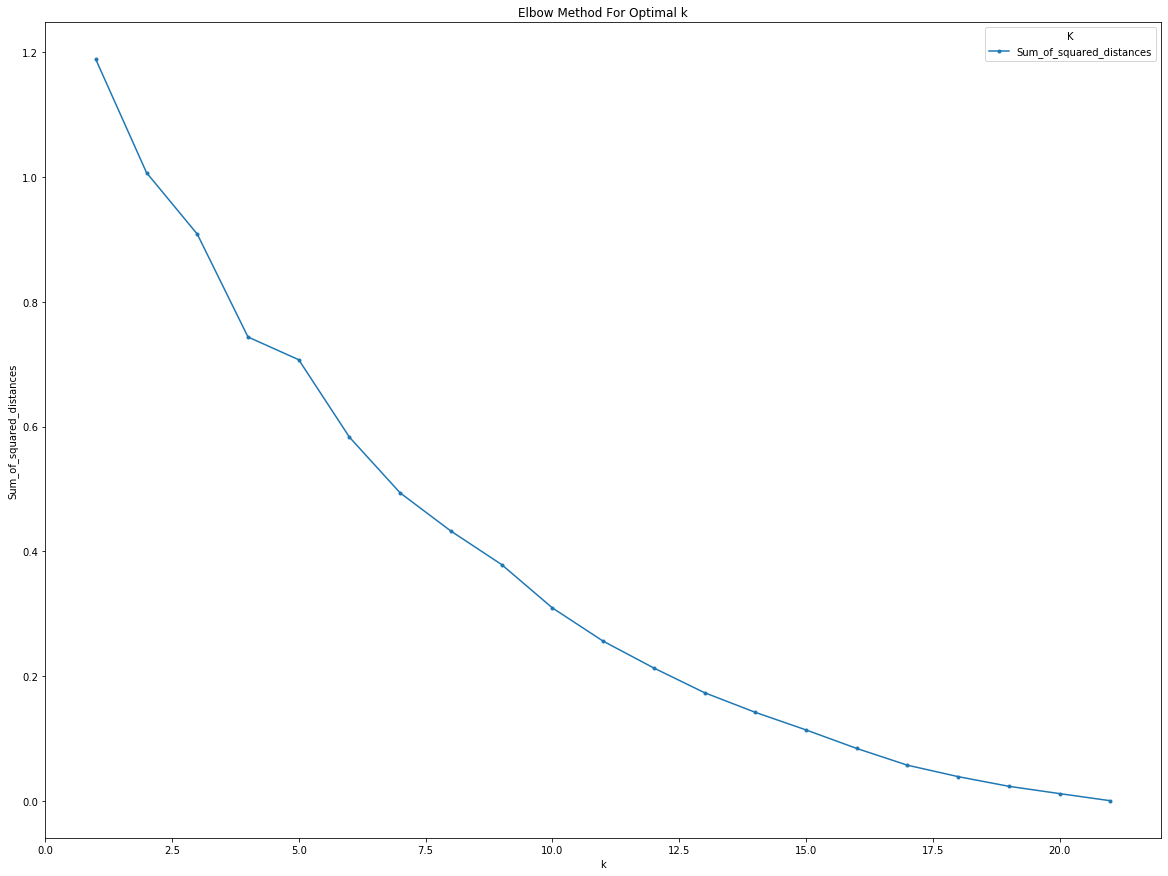

In [31]:
optimal_k.plot(kind = 'line', figsize = (20, 15), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

__It seems that our best suitable K value is 5.__

In [32]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 4, 0, 0, 0, 0, 4, 0, 1], dtype=int32)

#### Now let's put our cluster labels in our neighborhoods_venues_sorted df

First, we need to remove the rows in our original df for which the Foursquare call didn't return any venues

In [33]:
df['Neighborhood'] = neighborhoods_venues_sorted['Neighborhood']
print(df.shape)
df.isnull().sum()
df.dropna(how = 'any', axis = 0, inplace = True)
print(df.shape)
print(neighborhoods_venues_sorted.shape)

(39, 24)
(21, 24)
(21, 11)


## Segment the neighborhoods by population's nationalities and most common venues

#### we are going to create a new df that contains the cluster labels as well as the top 10 venues per neighborhood

In [34]:
madrid_merged = df

madrid_merged['Cluster Labels'] = kmeans.labels_

madrid_merged = madrid_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
madrid_merged[['Latitude', 'Longitude']] = coordinates_df[['Latitude', 'Longitude']]
madrid_merged['Latitude'] = madrid_merged['Latitude'].astype(float)
madrid_merged['Longitude'] = madrid_merged['Longitude'].astype(float)
print(madrid_merged.shape)

madrid_merged.head()

(21, 37)


,Country of Procedence,Total Ciudad de Madrid,Centro,Arganzuela,Retiro,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,Rumanía,45036.0,815.0,754.0,480.0,753.0,680.0,1468.0,597.0,1830.0,991.0,4904.0,5873.0,2241.0,4784.0,1286.0,2888.0,1466.0,3646.0,3384.0,2606.0,2929.0,661.0,Arganzuela,0,Restaurant,Spanish Restaurant,Grocery Store,Bakery,Tapas Restaurant,Falafel Restaurant,Hotel,Gym / Fitness Center,Bar,Breakfast Spot,40.415347,-3.707371
1,China,37276.0,1508.0,1356.0,564.0,755.0,652.0,1988.0,816.0,1733.0,960.0,2554.0,4398.0,9207.0,3602.0,564.0,1960.0,1104.0,1236.0,685.0,472.0,972.0,190.0,Barajas,0,Hotel,Restaurant,Spanish Restaurant,Tapas Restaurant,Coffee Shop,Bar,Brewery,Fast Food Restaurant,Japanese Restaurant,Bistro,40.402733,-3.695403
2,Ecuador,23953.0,647.0,741.0,265.0,619.0,380.0,1395.0,453.0,632.0,387.0,2194.0,3674.0,1806.0,3290.0,491.0,2471.0,401.0,2017.0,498.0,439.0,1015.0,138.0,Carabanchel,4,Soccer Field,Tapas Restaurant,Pizza Place,Burger Joint,Plaza,Fast Food Restaurant,Bakery,Nightclub,Food,Flea Market,40.408072,-3.676729
3,Venezuela,23359.0,1563.0,913.0,638.0,1564.0,933.0,1310.0,794.0,1428.0,630.0,1448.0,1870.0,875.0,1829.0,480.0,1858.0,1434.0,909.0,762.0,321.0,1486.0,314.0,Centro,0,Tapas Restaurant,Spanish Restaurant,Hostel,Plaza,Bistro,Cocktail Bar,Wine Bar,Restaurant,Bar,Market,40.430000,-3.677778
4,Colombia,22618.0,998.0,717.0,483.0,803.0,551.0,822.0,659.0,999.0,454.0,1786.0,3395.0,1752.0,1733.0,482.0,1792.0,910.0,1618.0,740.0,384.0,1282.0,258.0,Chamartin,0,Restaurant,Spanish Restaurant,Tapas Restaurant,Grocery Store,Bakery,Coffee Shop,Gastropub,Pizza Place,Japanese Restaurant,Park,40.453333,-3.677500


In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['Latitude'], madrid_merged['Longitude'], madrid_merged['Neighborhood'], madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Now we can examine our clusters

### Cluster One:

In [39]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 0, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Procedence'], ascending = False)

,Country of Procedence,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
3,Venezuela,1564.0,933.0,1310.0,794.0,1428.0,630.0,1448.0,1870.0,875.0,1829.0,480.0,1858.0,1434.0,909.0,762.0,321.0,1486.0,314.0,Centro,0,Tapas Restaurant,Spanish Restaurant,Hostel,Plaza,Bistro,Cocktail Bar,Wine Bar,Restaurant,Bar,Market,40.430000,-3.677778
0,Rumanía,753.0,680.0,1468.0,597.0,1830.0,991.0,4904.0,5873.0,2241.0,4784.0,1286.0,2888.0,1466.0,3646.0,3384.0,2606.0,2929.0,661.0,Arganzuela,0,Restaurant,Spanish Restaurant,Grocery Store,Bakery,Tapas Restaurant,Falafel Restaurant,Hotel,Gym / Fitness Center,Bar,Breakfast Spot,40.415347,-3.707371
19,Reino Unido,550.0,466.0,329.0,501.0,313.0,304.0,211.0,170.0,81.0,142.0,59.0,285.0,319.0,61.0,49.0,27.0,120.0,74.0,Villa de Vallecas,0,Breakfast Spot,Soccer Field,Platform,Grocery Store,Plaza,Spanish Restaurant,Bar,Church,Falafel Restaurant,Food,40.426001,-3.612764
13,Portugal,695.0,534.0,590.0,509.0,693.0,365.0,533.0,658.0,283.0,597.0,173.0,612.0,727.0,302.0,262.0,168.0,565.0,191.0,Retiro,0,Spanish Restaurant,Bar,Supermarket,Tapas Restaurant,Bakery,Museum,Grocery Store,Pizza Place,Mexican Restaurant,Polish Restaurant,40.409869,-3.644436
8,Paraguay,521.0,657.0,3311.0,584.0,1024.0,636.0,2061.0,2152.0,727.0,1354.0,360.0,1619.0,583.0,870.0,217.0,199.0,581.0,151.0,Hortaleza,0,Supermarket,Pizza Place,Breakfast Spot,Donut Shop,Clothing Store,Plaza,Pub,Restaurant,Chinese Restaurant,Sandwich Place,40.435151,-3.718765
5,Marruecos,322.0,280.0,1393.0,320.0,930.0,342.0,1539.0,2223.0,942.0,3437.0,258.0,1011.0,426.0,3372.0,1655.0,802.0,649.0,333.0,Chamberí,0,Spanish Restaurant,Restaurant,Bar,Brewery,Japanese Restaurant,Italian Restaurant,Café,Tapas Restaurant,Plaza,Hotel,40.460556,-3.700000
6,Italia,1817.0,1060.0,1194.0,1640.0,1195.0,710.0,826.0,915.0,412.0,704.0,310.0,1258.0,1109.0,330.0,427.0,189.0,786.0,337.0,Ciudad Lineal,0,Spanish Restaurant,Supermarket,Argentinian Restaurant,Gastropub,Restaurant,Burger Joint,Pharmacy,Ice Cream Shop,Mediterranean Restaurant,Music Venue,40.432792,-3.697186
10,Honduras,332.0,337.0,755.0,317.0,863.0,335.0,2021.0,2870.0,1115.0,2483.0,281.0,1062.0,349.0,1040.0,387.0,165.0,598.0,62.0,Moncloa-Aravaca,0,Restaurant,Spanish Restaurant,Sandwich Place,Bar,Ice Cream Shop,Pub,Italian Restaurant,Japanese Restaurant,Pizza Place,Tapas Restaurant,40.383669,-3.727989
14,Francia,968.0,554.0,387.0,699.0,366.0,347.0,196.0,188.0,66.0,138.0,85.0,599.0,1802.0,68.0,59.0,52.0,357.0,197.0,Salamanca,0,Spanish Restaurant,Mediterranean Restaurant,Restaurant,Seafood Restaurant,Mexican Restaurant,Gymnastics Gym,Burger Joint,Tapas Restaurant,Supermarket,Bakery,40.450000,-3.650000
12,Filipinas,578.0,661.0,4473.0,771.0,442.0,568.0,629.0,400.0,225.0,418.0,76.0,590.0,300.0,140.0,25.0,24.0,152.0,30.0,Puente de Vallecas,0,Fast Food Restaurant,Supermarket,Tapas Restaurant,Gym,Grocery Store,Hotel,Market,Burger Joint,Breakfast Spot,Seafood Restaurant,40.398204,-3.669059


### Cluster two

In [40]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 1, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Procedence'], ascending = False)

,Country of Procedence,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
9,República Dominicana,344.0,322.0,2272.0,443.0,589.0,536.0,1501.0,1607.0,1202.0,1989.0,223.0,1581.0,359.0,1881.0,296.0,151.0,889.0,103.0,Latina,1,Pizza Place,Metro Station,Food & Drink Shop,Fast Food Restaurant,Falafel Restaurant,Bar,Bakery,Train Station,Park,Donut Shop,40.402461,-3.741294


### Cluster three

In [41]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 2, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Procedence'], ascending = False)

,Country of Procedence,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
20,Bangladesh,32.0,21.0,210.0,48.0,27.0,14.0,257.0,410.0,175.0,649.0,23.0,179.0,27.0,489.0,57.0,32.0,78.0,2.0,Villaverde,2,Pizza Place,Diner,Burger Joint,Spanish Restaurant,Dessert Shop,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,40.470196,-3.58489


### Cluster four

In [42]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 3, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Procedence'], ascending = False)

,Country of Procedence,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
15,Ucrania,220.0,176.0,221.0,149.0,312.0,168.0,1745.0,1251.0,428.0,912.0,239.0,348.0,282.0,1649.0,256.0,152.0,390.0,56.0,San Blas-Canillejas,3,Metro Station,Shopping Mall,Snack Place,Pizza Place,Gym,Grocery Store,Asian Restaurant,Gas Station,Supermarket,Falafel Restaurant,40.469457,-3.640482


### Cluster ffive

In [43]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 4, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Procedence'], ascending = False)


,Country of Procedence,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
7,Perú,612.0,419.0,965.0,567.0,805.0,368.0,2026.0,2425.0,1131.0,2079.0,668.0,1726.0,603.0,1280.0,564.0,338.0,810.0,106.0,Fuencarral-El Pardo,4,Clothing Store,Fast Food Restaurant,Italian Restaurant,Tapas Restaurant,Bakery,Restaurant,Burger Joint,Sandwich Place,Kebab Restaurant,Chocolate Shop,40.478611,-3.709722
2,Ecuador,619.0,380.0,1395.0,453.0,632.0,387.0,2194.0,3674.0,1806.0,3290.0,491.0,2471.0,401.0,2017.0,498.0,439.0,1015.0,138.0,Carabanchel,4,Soccer Field,Tapas Restaurant,Pizza Place,Burger Joint,Plaza,Fast Food Restaurant,Bakery,Nightclub,Food,Flea Market,40.408072,-3.676729
11,Bolivia,342.0,315.0,576.0,280.0,401.0,225.0,1458.0,2625.0,2827.0,1573.0,227.0,1086.0,479.0,737.0,222.0,159.0,454.0,71.0,Moratalaz,4,Brewery,Bar,Pizza Place,Nightclub,Plaza,Restaurant,Café,Metro Station,Shopping Mall,Soccer Field,40.381336,-3.706856


## CONCLUSSION

As far as we are able to see with this data, there are no mexican populations registered in Madrid. However, in Cluster 1, it is possible to notice that there's a mexican restaurant located in the "Centro" neighborhood, which is the town center.

If a deeper exam is performed into this cluster, it is noticeable that its the living population are mostly latinos, mixed with some other europeans, but mainly, the people living in this cluster come from south american countries. Apart of this fact, other kinds of latin restaurants can be found, like argetinian restaurants, tapas restaurants, and italian restaurants. So it is possible to tell that the inhabitants of this area likes these kinds of food.

By following this logic, if we would like to open a new mexican restaurant in the city or any kind of restaurant in fact, it would only be necessary to find a where are the restaurants similar the the one we want to open, study the population in that area, and find similar clusters of population in the city that don't have yet or have very few resturants like the one we would like to open.

In this example, clusters 4 and 5 could make a good match for our target population. Looking at the venues in these clusters, it is possible to find one mexican restaurant, and a good bunch of fast food, argentinian, and south american restaurants. So, in these clusters, it is possible to state that the existing restaurants matches the population's nationalities and tastes.

In conlussion, and taking into consideration the explanations given above as well as the data, __it is highly possible that clusters 4 and five could be a good place to open our mexican restaurants.__ As explained above, the same logic could apply to oopen other kind of restaurant or business in any other area of the city. It is only necessary to to examine the the existing businesses in our target area, and study the population, then compare these 2 factors with the same ones in areas where there are existing business like the one we want to open, and then verify if the matching is correct.